## Practice: Basic Artificial Neural Networks

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

In [ ]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

In [ ]:
# (re-)load layers
%run modules.ipynb

test_BatchNormalization (__main__.TestLayers) ... ok
test_ClassNLLCriterion (__main__.TestLayers) ... ok
test_ClassNLLCriterionUnstable (__main__.TestLayers) ... ok
test_Dropout (__main__.TestLayers) ... ok
test_ELU (__main__.TestLayers) ... ok
test_LeakyReLU (__main__.TestLayers) ... ok
test_Linear (__main__.TestLayers) ... ok
test_LogSoftMax (__main__.TestLayers) ... ok
test_Sequential (__main__.TestLayers) ... FAIL
test_SoftMax (__main__.TestLayers) ... ok
test_SoftPlus (__main__.TestLayers) ... ok
test_adam_optimizer (__main__.TestLayers) ... ok

FAIL: test_Sequential (__main__.TestLayers)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-21-7667c192de41>", line 169, in test_Sequential
    self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))
AssertionError: False is not true

----------------------------------------------------------------------
Ran 12 tests i

# Toy example

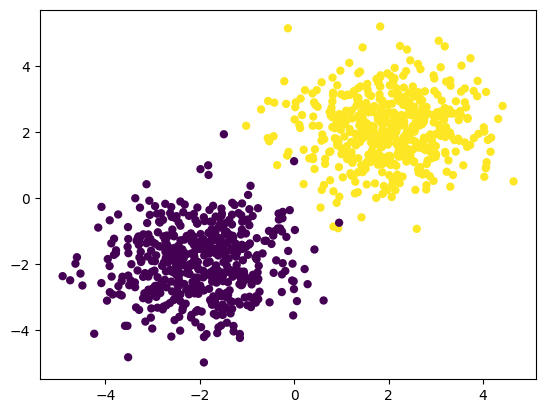

In [ ]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

In [ ]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Starting with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [ ]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop.

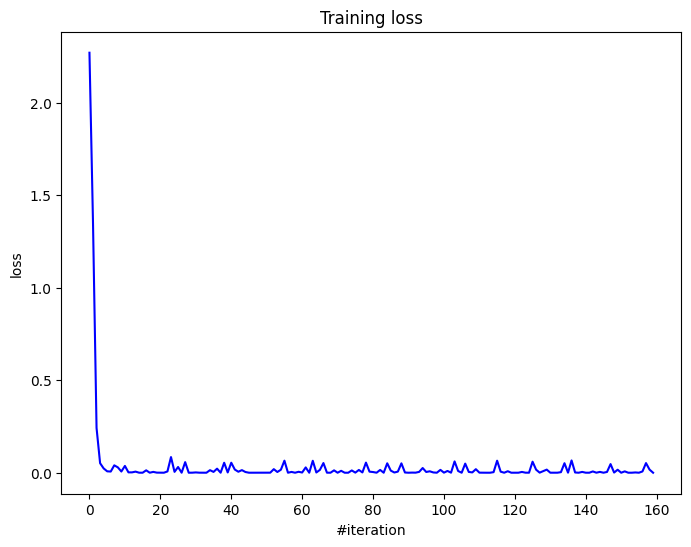

Current loss: 0.000061


In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

In [ ]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [ ]:
X_train.shape

(50000, 28, 28)

One-hot encoding the labels first.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

X_train = np.expand_dims(X_train, 1)
X_val = np.expand_dims(X_val, 1)
X_test = np.expand_dims(X_test, 1)

encoder = OneHotEncoder(categories='auto', sparse=False)

y_train = encoder.fit_transform(y_train.reshape(-1, 1))

In [ ]:
X_train.shape

(50000, 1, 28, 28)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

Сначала попробуем разные функции активации, а затем к лучшей из них применим `BatchNormalization`.

In [ ]:
X_train, X_val, X_test = list(map(lambda x: x.reshape((x.shape[0], -1)), [X_train, X_val, X_test]))

In [ ]:
X_train.shape

(50000, 784)

In [ ]:
optimizer_config = {'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5, 'momentum' : 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [ ]:
net1 = Sequential()
net1.add(Linear(784, 128))
net1.add(ReLU())
net1.add(Linear(128, 10))
net1.add(LogSoftMax())

net2 = Sequential()
net2.add(Linear(784, 128))
net2.add(ELU())
net2.add(Linear(128, 10))
net2.add(LogSoftMax())

net3 = Sequential()
net3.add(Linear(784, 128))
net3.add(LeakyReLU())
net3.add(Linear(128, 10))
net3.add(LogSoftMax())

net4 = Sequential()
net4.add(Linear(784, 128))
net4.add(SoftPlus())
net4.add(Linear(128, 10))
net4.add(LogSoftMax())

criterion = ClassNLLCriterion()
nets_array = [net1, net2, net3, net4]
print(net1, net2, net3, net4)

Linear 784 -> 128
ReLU
Linear 128 -> 10
LogSoftMax
 Linear 784 -> 128
ELU
Linear 128 -> 10
LogSoftMax
 Linear 784 -> 128
LeakyReLU
Linear 128 -> 10
LogSoftMax
 Linear 784 -> 128
SoftPlus
Linear 128 -> 10
LogSoftMax



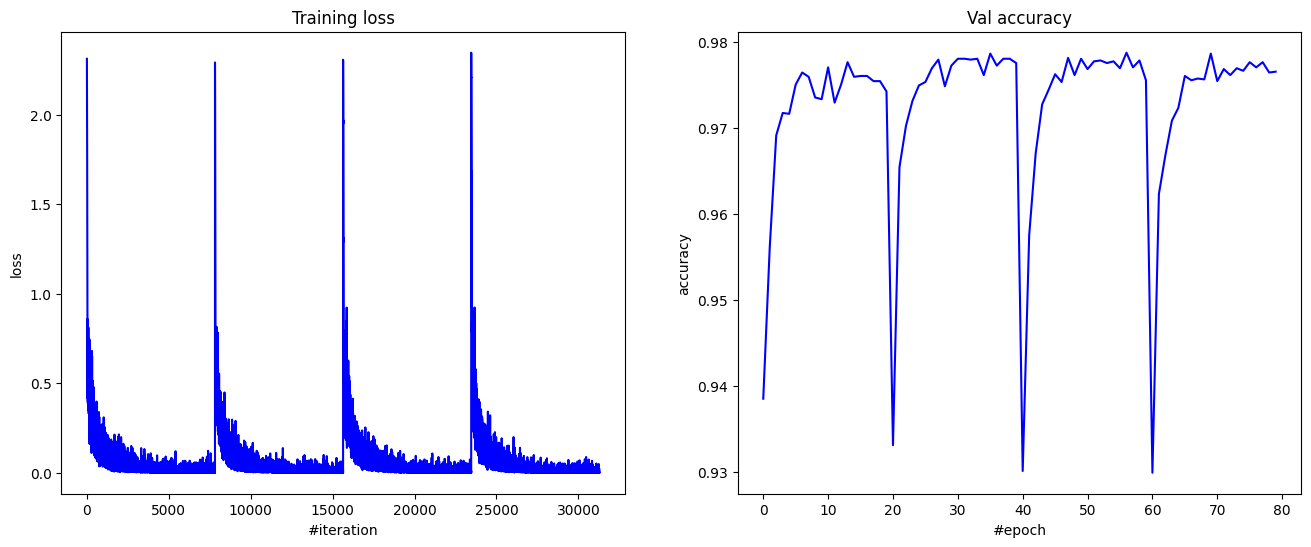

Current loss: 0.000089
For activation function ReLU
 Min loss = 5.666381033447327e-05
 Max accuracy = 0.9776
For activation function ELU
 Min loss = 1.0789504951633727e-05
 Max accuracy = 0.9786
For activation function LeakyReLU
 Min loss = 1.4335838115338044e-05
 Max accuracy = 0.9787
For activation function SoftPlus
 Min loss = 1.0112665212839022e-05
 Max accuracy = 0.9786


In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

loss_history = []
accuracy_history = []
names = {net1 : 'ReLU', net2 : 'ELU', net3 : 'LeakyReLU', net4 : 'SoftPlus'}

sp = []

for net in nets_array:
  max_accuracy = 0
  min_loss = 1e9
  for i in range(n_epoch):
      net.train()
      for x_batch, y_batch in tqdm(get_batches((X_train, y_train), batch_size)):

          net.zeroGradParameters()

          # Forward
          predictions = net.forward(x_batch)
          loss = criterion.forward(predictions, y_batch)

          # Backward
          dp = criterion.backward(predictions, y_batch)
          net.backward(x_batch, dp)

          # Update weights
          adam_optimizer(net.getParameters(),
                      net.getGradParameters(),
                      optimizer_config,
                      optimizer_state)
          min_loss = min(min_loss, loss)
          loss_history.append(loss)

      net.evaluate()
      max_accuracy = max(max_accuracy, accuracy_score(net.forward(X_val).argmax(axis=-1), y_val))
      accuracy_history.append(accuracy_score(net.forward(X_val).argmax(axis=-1), y_val))

      # Visualize
      display.clear_output(wait=True)
      plt.figure(figsize=(16, 6))

      plt.subplot(1, 2, 1)
      plt.title("Training loss")
      plt.xlabel("#iteration")
      plt.ylabel("loss")
      plt.plot(loss_history, 'b')

      plt.subplot(1, 2, 2)
      plt.title("Val accuracy")
      plt.xlabel("#epoch")
      plt.ylabel("accuracy")
      plt.plot(accuracy_history, 'b')
      plt.show()

      print('Current loss: %f' % loss)
  sp.append('For activation function ' + names[net] + '\n Min loss = ' + str(min_loss) + '\n Max accuracy = ' + str(max_accuracy))
for i in sp:
  print(i)

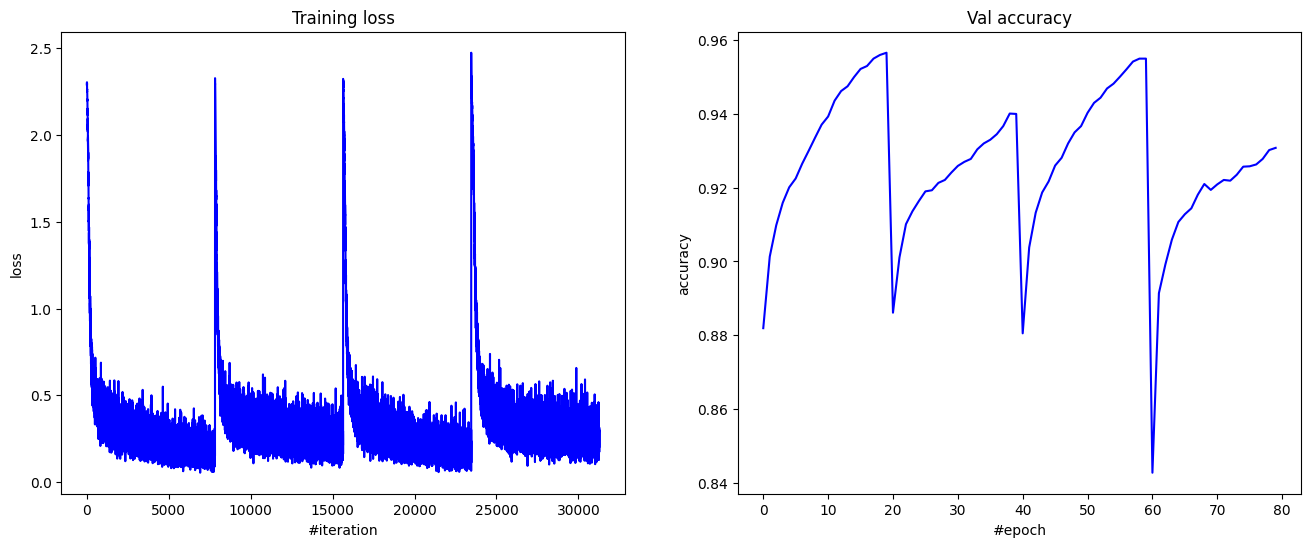

Current loss: 0.297240
For activation function ReLU
 Min loss = 0.05388727535062541
 Max accuracy = 0.9566
For activation function ELU
 Min loss = 0.08244893010798306
 Max accuracy = 0.9401
For activation function LeakyReLU
 Min loss = 0.05738767935202646
 Max accuracy = 0.955
For activation function SoftPlus
 Min loss = 0.09349680880837094
 Max accuracy = 0.9308


In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

loss_history = []
accuracy_history = []
names = {net1 : 'ReLU', net2 : 'ELU', net3 : 'LeakyReLU', net4 : 'SoftPlus'}

sp = []

for net in nets_array:
  max_accuracy = 0
  min_loss = 1e9
  for i in range(n_epoch):
      net.train()
      for x_batch, y_batch in tqdm(get_batches((X_train, y_train), batch_size)):

          net.zeroGradParameters()

          # Forward
          predictions = net.forward(x_batch)
          loss = criterion.forward(predictions, y_batch)

          # Backward
          dp = criterion.backward(predictions, y_batch)
          net.backward(x_batch, dp)

          # Update weights
          sgd_momentum(net.getParameters(),
                      net.getGradParameters(),
                      optimizer_config,
                      optimizer_state)

          min_loss = min(min_loss, loss)
          loss_history.append(loss)

      net.evaluate()
      max_accuracy = max(max_accuracy, accuracy_score(net.forward(X_val).argmax(axis=-1), y_val))
      accuracy_history.append(accuracy_score(net.forward(X_val).argmax(axis=-1), y_val))

      # Visualize
      display.clear_output(wait=True)
      plt.figure(figsize=(16, 6))

      plt.subplot(1, 2, 1)
      plt.title("Training loss")
      plt.xlabel("#iteration")
      plt.ylabel("loss")
      plt.plot(loss_history, 'b')

      plt.subplot(1, 2, 2)
      plt.title("Val accuracy")
      plt.xlabel("#epoch")
      plt.ylabel("accuracy")
      plt.plot(accuracy_history, 'b')
      plt.show()

      print('Current loss: %f' % loss)
  sp.append('For activation function ' + names[net] + '\n Min loss = ' + str(min_loss) + '\n Max accuracy = ' + str(max_accuracy))
for i in sp:
  print(i)

Since it is difficult to say from accuracy which activation function performed best, we will apply `BatchNormalization` to all of them as well and look at the results.

In [ ]:
net1 = Sequential()
net1.add(Linear(784, 128))
net1.add(BatchNormalization(alpha = 0.5))
net1.add(ReLU())
net1.add(Linear(128, 10))
net1.add(LogSoftMax())

net2 = Sequential()
net2.add(Linear(784, 128))
net2.add(BatchNormalization(alpha = 0.5))
net2.add(ELU())
net2.add(Linear(128, 10))
net2.add(LogSoftMax())

net3 = Sequential()
net3.add(Linear(784, 128))
net3.add(BatchNormalization(alpha = 0.5))
net3.add(LeakyReLU())
net3.add(Linear(128, 10))
net3.add(LogSoftMax())

net4 = Sequential()
net4.add(Linear(784, 128))
net4.add(BatchNormalization(alpha = 0.5))
net4.add(SoftPlus())
net4.add(Linear(128, 10))
net4.add(LogSoftMax())

criterion = ClassNLLCriterion()
nets_array = [net1, net2, net3, net4]
print(net1, net2, net3, net4)

Linear 784 -> 128
BatchNormalization
ReLU
Linear 128 -> 10
LogSoftMax
 Linear 784 -> 128
BatchNormalization
ELU
Linear 128 -> 10
LogSoftMax
 Linear 784 -> 128
BatchNormalization
LeakyReLU
Linear 128 -> 10
LogSoftMax
 Linear 784 -> 128
BatchNormalization
SoftPlus
Linear 128 -> 10
LogSoftMax



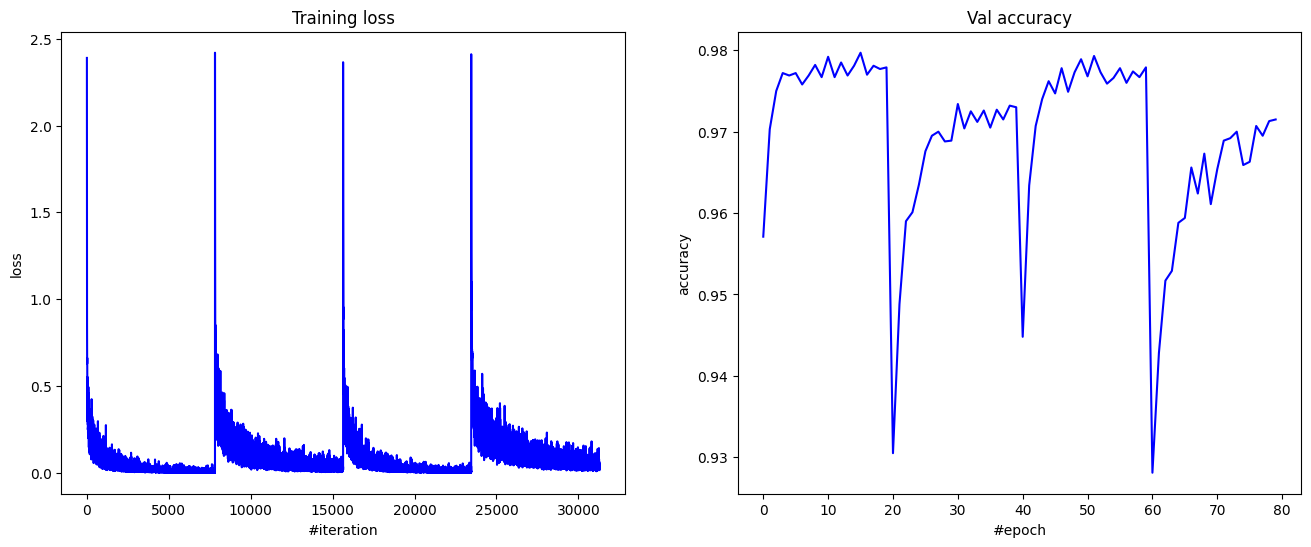

Current loss: 0.015773
For activation function ReLU
 Min loss = 0.00032905875433566513
 Max accuracy = 0.9797
For activation function ELU
 Min loss = 0.003098902936014122
 Max accuracy = 0.9734
For activation function LeakyReLU
 Min loss = 0.0003487458407415202
 Max accuracy = 0.9793
For activation function SoftPlus
 Min loss = 0.008673704676319425
 Max accuracy = 0.9715


In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

loss_history = []
accuracy_history = []
names = {net1 : 'ReLU', net2 : 'ELU', net3 : 'LeakyReLU', net4 : 'SoftPlus'}

sp = []

for net in nets_array:
  max_accuracy = 0
  min_loss = 1e9
  for i in range(n_epoch):
      net.train()
      for x_batch, y_batch in tqdm(get_batches((X_train, y_train), batch_size)):

          net.zeroGradParameters()

          # Forward
          predictions = net.forward(x_batch)
          loss = criterion.forward(predictions, y_batch)

          # Backward
          dp = criterion.backward(predictions, y_batch)
          net.backward(x_batch, dp)

          # Update weights
          adam_optimizer(net.getParameters(),
                      net.getGradParameters(),
                      optimizer_config,
                      optimizer_state)
          min_loss = min(min_loss, loss)
          loss_history.append(loss)

      net.evaluate()
      max_accuracy = max(max_accuracy, accuracy_score(net.forward(X_val).argmax(axis=-1), y_val))
      accuracy_history.append(accuracy_score(net.forward(X_val).argmax(axis=-1), y_val))

      # Visualize
      display.clear_output(wait=True)
      plt.figure(figsize=(16, 6))

      plt.subplot(1, 2, 1)
      plt.title("Training loss")
      plt.xlabel("#iteration")
      plt.ylabel("loss")
      plt.plot(loss_history, 'b')

      plt.subplot(1, 2, 2)
      plt.title("Val accuracy")
      plt.xlabel("#epoch")
      plt.ylabel("accuracy")
      plt.plot(accuracy_history, 'b')
      plt.show()

      print('Current loss: %f' % loss)
  sp.append('For activation function ' + names[net] + '\n Min loss = ' + str(min_loss) + '\n Max accuracy = ' + str(max_accuracy))
for i in sp:
  print(i)

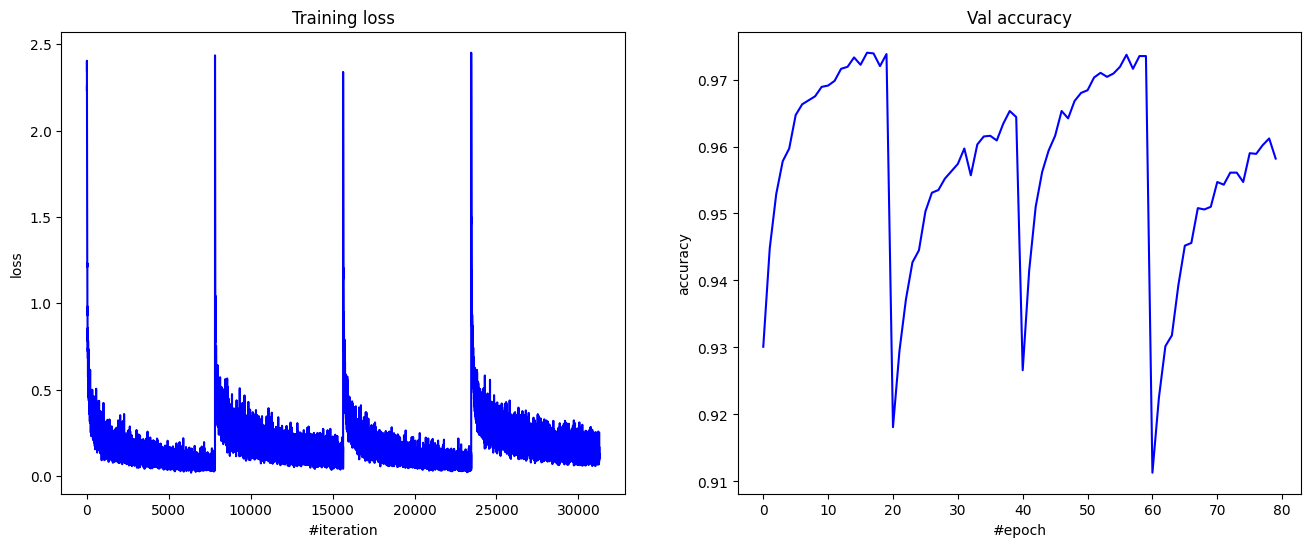

Current loss: 0.246376
For activation function ReLU
 Min loss = 0.01798417980517824
 Max accuracy = 0.974
For activation function ELU
 Min loss = 0.0345040724889104
 Max accuracy = 0.9653
For activation function LeakyReLU
 Min loss = 0.02116783372927908
 Max accuracy = 0.9737
For activation function SoftPlus
 Min loss = 0.0563671665338904
 Max accuracy = 0.9612


In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

loss_history = []
accuracy_history = []
names = {net1 : 'ReLU', net2 : 'ELU', net3 : 'LeakyReLU', net4 : 'SoftPlus'}

sp = []

for net in nets_array:
  max_accuracy = 0
  min_loss = 1e9
  for i in range(n_epoch):
      net.train()
      for x_batch, y_batch in tqdm(get_batches((X_train, y_train), batch_size)):

          net.zeroGradParameters()

          # Forward
          predictions = net.forward(x_batch)
          loss = criterion.forward(predictions, y_batch)

          # Backward
          dp = criterion.backward(predictions, y_batch)
          net.backward(x_batch, dp)

          # Update weights
          sgd_momentum(net.getParameters(),
                      net.getGradParameters(),
                      optimizer_config,
                      optimizer_state)

          min_loss = min(min_loss, loss)
          loss_history.append(loss)

      net.evaluate()
      max_accuracy = max(max_accuracy, accuracy_score(net.forward(X_val).argmax(axis=-1), y_val))
      accuracy_history.append(accuracy_score(net.forward(X_val).argmax(axis=-1), y_val))

      # Visualize
      display.clear_output(wait=True)
      plt.figure(figsize=(16, 6))

      plt.subplot(1, 2, 1)
      plt.title("Training loss")
      plt.xlabel("#iteration")
      plt.ylabel("loss")
      plt.plot(loss_history, 'b')

      plt.subplot(1, 2, 2)
      plt.title("Val accuracy")
      plt.xlabel("#epoch")
      plt.ylabel("accuracy")
      plt.plot(accuracy_history, 'b')
      plt.show()

      print('Current loss: %f' % loss)
  sp.append('For activation function ' + names[net] + '\n Min loss = ' + str(min_loss) + '\n Max accuracy = ' + str(max_accuracy))
for i in sp:
  print(i)

If we talk about whether `BatchNormalization` helped, then with sgd_momentum it increased the accuracy quite a lot (by almost 3-4 percent for each activation function), and if we talk about Adam optimizer, then somewhere it became better, and somewhere worse, but in general we can say that nothing has changed. If we talk about activation functions, then on average Leaky ReLU performed best.

In [ ]:
optimizer_config = {'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5, 'momentum' : 0.9}
optimizer_state = {}
criterion = ClassNLLCriterion()

# Looping params
n_epoch = 20
batch_size = 128
net = Sequential()
net.add(Linear(784, 128))
net.add(BatchNormalization(alpha = 0.5))
net.add(LeakyReLU())
net.add(Dropout(p = 0.1))
net.add(Linear(128, 10))
net.add(LogSoftMax())

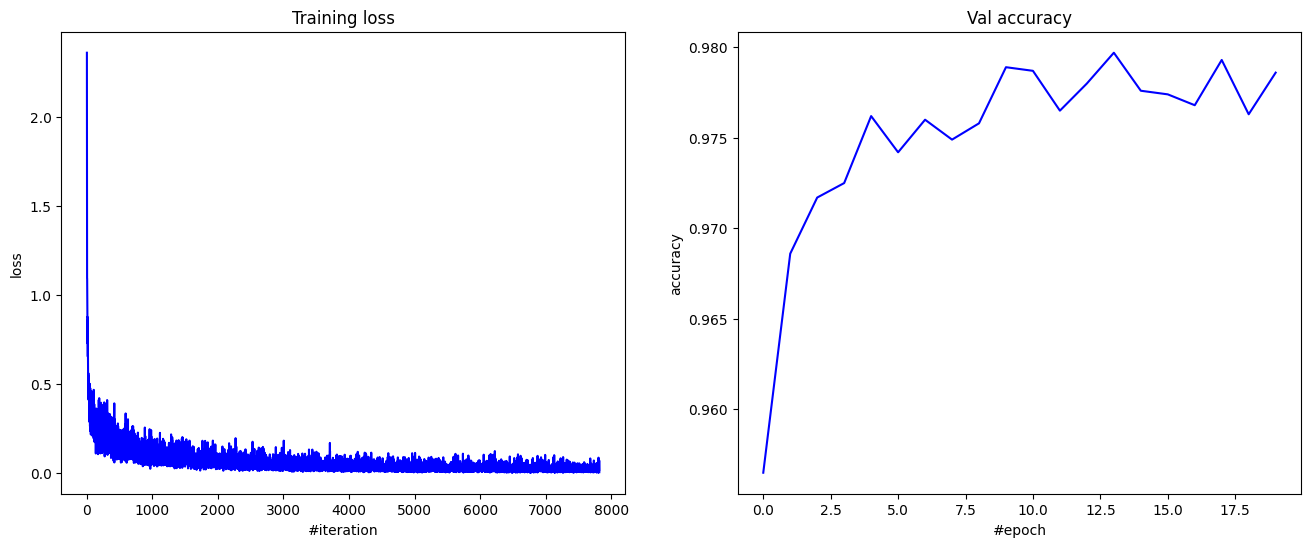

Current loss: 0.004702


In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

loss_history = []
accuracy_history = []


for i in range(n_epoch):
    net.train()
    for x_batch, y_batch in tqdm(get_batches((X_train, y_train), batch_size)):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        adam_optimizer(net.getParameters(),
                    net.getGradParameters(),
                    optimizer_config,
                    optimizer_state)
        loss_history.append(loss)

    net.evaluate()
    accuracy_history.append(accuracy_score(net.forward(X_val).argmax(axis=-1), y_val))

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')

    plt.subplot(1, 2, 2)
    plt.title("Val accuracy")
    plt.xlabel("#epoch")
    plt.ylabel("accuracy")
    plt.plot(accuracy_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

In [ ]:
net.evaluate()
accuracy = accuracy_score(net.forward(X_test).argmax(axis=-1), y_test)

In [ ]:
print(accuracy)

0.9791


### Comparing with PyTorch implementation

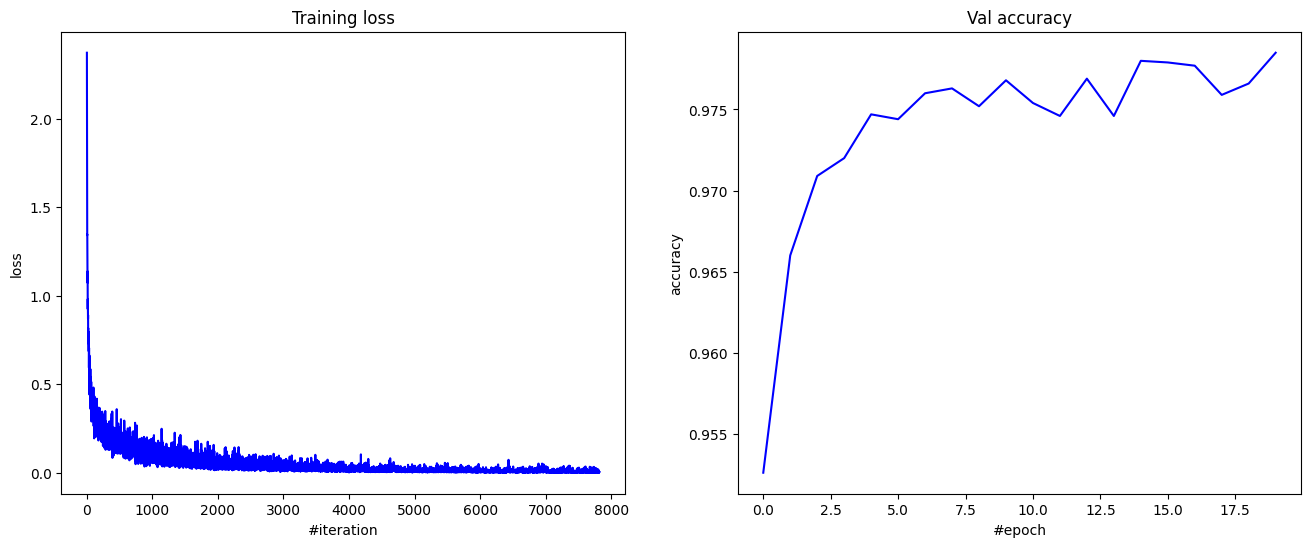

Current loss: 0.004546


In [ ]:
import torch.nn as nn
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch as tr


loss_func = nn.CrossEntropyLoss()
net = nn.Sequential(nn.Linear(784, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Linear(128, 10))
lr = 1e-3
opt = tr.optim.Adam(net.parameters(), lr=lr)
loss_history = []
accuracy_history = []

for i in range(n_epoch):
      net.train()
      for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
          x_batch = tr.from_numpy(x_batch)
          y_batch = tr.from_numpy(y_batch)


          # Forward
          predictions = net(x_batch)
          loss = loss_func(predictions, y_batch)

          # Backward
          dp = criterion.backward(predictions, y_batch)

          # Update weights

          # train with backprop
          loss.backward()
          opt.step()
          opt.zero_grad()

          loss_history.append(loss.detach().numpy())

      net.eval()
      accuracy_history.append(accuracy_score(net.forward(tr.from_numpy(X_val)).argmax(axis=-1), tr.from_numpy(y_val)))

      # Visualize
      display.clear_output(wait=True)
      plt.figure(figsize=(16, 6))

      plt.subplot(1, 2, 1)
      plt.title("Training loss")
      plt.xlabel("#iteration")
      plt.ylabel("loss")
      plt.plot(loss_history, 'b')

      plt.subplot(1, 2, 2)
      plt.title("Val accuracy")
      plt.xlabel("#epoch")
      plt.ylabel("accuracy")
      plt.plot(accuracy_history, 'b')
      plt.show()

      print('Current loss: %f' % loss)

We see that the results haven’t gotten much better, which means our modules are written quite well!